In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
import backtrader as bt
import pyfolio as pf

### Parameters

In [3]:
ticker = 'AAPL'
days=[5, 20]
return_days = 5
extreme = 4
test_date_start = datetime(2013,1,1)
test_date = test_date_start.strftime('%Y-%m-%d')
test_date_end = datetime(2017,1,1)
filename = '{}_{}_{}.h5py'.format(ticker, return_days, extreme)

In [4]:
aal = pdr.get_data_google(ticker, '2000-01-01', '2017-01-01')

In [5]:
aal.drop('Volume', axis=1, inplace=True)
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,1.44,1.53,1.43,1.51
2001-02-07,1.48,1.49,1.42,1.48
2001-02-08,1.47,1.50,1.44,1.48
2001-02-09,1.46,1.49,1.33,1.37
2001-02-12,1.36,1.43,1.34,1.41


In [6]:
def _set_index_column_if_necessary(data: pd.DataFrame) -> pd.DataFrame:
    if 'Date' in data.columns:
        data.set_index('Date', inplace=True)
    return data

In [7]:
aal = _set_index_column_if_necessary(aal)
cols = aal.columns
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,1.44,1.53,1.43,1.51
2001-02-07,1.48,1.49,1.42,1.48
2001-02-08,1.47,1.50,1.44,1.48
2001-02-09,1.46,1.49,1.33,1.37
2001-02-12,1.36,1.43,1.34,1.41


In [8]:
cols

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
def feature(data, first_col, second_col):
    return data[first_col]/data[second_col]

In [10]:
def create_extra_columns(data, cols):
    pool = []
    for left, right in itertools.product(cols, cols):
        pair1 = left + right
        pair2 = right + left
        if left != right and pair1 not in pool and pair2 not in pool:
            aal[left + '/' + right] = feature(data, left, right)
            pool.append(pair1)

### Rolling features

In [11]:
# for col, day in itertools.product(cols, days):
#     aal[col + ' ' + str(day) + ' MA'] = aal[col].rolling(day).mean()
#     aal[col + ' ' + str(day) + ' max'] = aal[col].rolling(day).max()
#     aal[col + ' ' + str(day) + ' min'] = aal[col].rolling(day).min()
aal.dropna(inplace=True)

In [12]:
aal.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [13]:
plain_features = list(filter(lambda col: '/' not in col, aal.columns))

In [14]:
create_extra_columns(aal, plain_features)

In [15]:
ret = 100*aal['Close'].pct_change(return_days).shift(-return_days)

In [16]:
# ret_dev = ret.rolling(10).std().fillna(1)

# ret_scaled = ret/ret_dev
# ret_scaled.head()

In [17]:
features_to_drop = list(filter(lambda col: '/' not in col, aal.columns))
aal.drop(features_to_drop, axis=1, inplace=True)

aal['Return'] = ret # ret_scaled
aal.head(10)

,Open/High,Open/Low,Open/Close,High/Low,High/Close,Low/Close,Return
Date,,,,,,,
2001-02-06,0.941176,1.006993,0.953642,1.069930,1.013245,0.947020,-9.271523
2001-02-07,0.993289,1.042254,1.000000,1.049296,1.006757,0.959459,-6.081081
2001-02-08,0.980000,1.020833,0.993243,1.041667,1.013514,0.972973,-3.378378
2001-02-09,0.979866,1.097744,1.065693,1.120301,1.087591,0.970803,-0.729927
2001-02-12,0.951049,1.014925,0.964539,1.067164,1.014184,0.950355,-7.092199
2001-02-13,0.972603,1.044118,1.036496,1.073529,1.065693,0.992701,-1.459854
2001-02-14,0.971631,1.037879,0.985612,1.068182,1.014388,0.949640,-3.597122
2001-02-15,0.959184,1.007143,0.986014,1.050000,1.027972,0.979021,-6.293706
2001-02-16,0.978417,1.014925,1.000000,1.037313,1.022059,0.985294,2.205882


In [18]:
len(aal.columns)

7

In [19]:
list(aal.columns)[:5]

['Open/High', 'Open/Low', 'Open/Close', 'High/Low', 'High/Close']

# X/y spit

In [20]:
aal.dropna(inplace=True)
aal.replace([np.inf, -np.inf], 1, inplace=True)
X_data = aal.drop('Return', axis=1)
y_data = aal['Return']

In [21]:
X_data.head(2)

,Open/High,Open/Low,Open/Close,High/Low,High/Close,Low/Close
Date,,,,,,
2001-02-06,0.941176,1.006993,0.953642,1.069930,1.013245,0.947020
2001-02-07,0.993289,1.042254,1.000000,1.049296,1.006757,0.959459


In [22]:
y_data.head(2)

Date
2001-02-06   -9.271523
2001-02-07   -6.081081
Name: Return, dtype: float64

In [23]:
def series_to_binarized_columns(y):
    pos = y > extreme
    neg = y < -extreme
    meds = (y > -extreme) & (y < extreme)
    y = np.array([neg, meds, pos]).T
    return y

In [24]:
X_train = X_data[:test_date]
X_test = X_data[test_date:]
y_train = y_data[:test_date]
y_test = y_data[test_date:]

In [25]:
y_train = series_to_binarized_columns(y_train)
y_test = series_to_binarized_columns(y_test)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [27]:
X_test_df = X_test.copy()
X_test = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns, index=X_test_df.index)

In [28]:
X_test_df.head(1)

,Open/High,Open/Low,Open/Close,High/Low,High/Close,Low/Close
Date,,,,,,
2013-01-02,0.871265,0.307639,0.393296,-0.390331,-0.296534,0.200886


# KERAS

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [31]:
def expand(X, axis=1):
    return np.expand_dims(X, axis=axis)

In [32]:
temp_y = np.argmax(y_train, axis=1)
cw = class_weight.compute_class_weight('balanced', np.unique(temp_y), temp_y)
cw

array([ 1.97101449,  0.58805031,  1.26244726])

In [33]:
input_shape = (1, 1, X_train.shape[1])
input_shape

(1, 1, 6)

In [40]:
def build_and_run():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, batch_input_shape=input_shape, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='glorot_uniform'))
    model.add(Activation('softmax'))

    model.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    for i in range(30):
        print(f'Iteration {i}')
        model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=5, shuffle=False, verbose=2)
        model.reset_states()
    model.save(filename)
    return model

In [41]:
#model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=100, shuffle=False, verbose=2) # , validation_data=(expand(X_test), y_test)

In [42]:
try:
    model = load_model(filename)
except:
    model = build_and_run()

Iteration 0
Epoch 1/5
 - 9s - loss: 0.9833 - acc: 0.5588
Epoch 2/5
 - 8s - loss: 0.9634 - acc: 0.5588
Epoch 3/5
 - 8s - loss: 0.9626 - acc: 0.5585
Epoch 4/5
 - 8s - loss: 0.9597 - acc: 0.5665
Epoch 5/5
 - 8s - loss: 0.9606 - acc: 0.5628
Iteration 1
Epoch 1/5
 - 8s - loss: 0.9583 - acc: 0.5652
Epoch 2/5
 - 8s - loss: 0.9593 - acc: 0.5648
Epoch 3/5
 - 8s - loss: 0.9576 - acc: 0.5652
Epoch 4/5
 - 8s - loss: 0.9567 - acc: 0.5638
Epoch 5/5
 - 8s - loss: 0.9581 - acc: 0.5685
Iteration 2
Epoch 1/5
 - 8s - loss: 0.9572 - acc: 0.5648
Epoch 2/5
 - 8s - loss: 0.9567 - acc: 0.5662
Epoch 3/5
 - 8s - loss: 0.9562 - acc: 0.5638
Epoch 4/5
 - 8s - loss: 0.9559 - acc: 0.5682
Epoch 5/5
 - 9s - loss: 0.9564 - acc: 0.5648
Iteration 3
Epoch 1/5
 - 8s - loss: 0.9538 - acc: 0.5652
Epoch 2/5
 - 8s - loss: 0.9554 - acc: 0.5675
Epoch 3/5
 - 8s - loss: 0.9533 - acc: 0.5695
Epoch 4/5
 - 8s - loss: 0.9530 - acc: 0.5665
Epoch 5/5
 - 8s - loss: 0.9542 - acc: 0.5675
Iteration 4
Epoch 1/5
 - 8s - loss: 0.9527 - acc: 0.

In [43]:
class ModelEvaluator:
    def __init__(self,
                 model):
        self.model = model

    def evaluate(self, X, y, ret):
        all_returns = []
        for c in [0.34 + x/50 for x in range(35)]:
            print('=================')
            print(f'Certainty is {c}')
            returns = self.calculate_returns(X, y, ret, c)
            cont = self.print_returns_distribution(returns)
            if not cont:
                break

    def calculate_returns(self, X, y, ret, certainty):
        predicted = self.model.predict(expand(X), batch_size=1)
        real_ups = y[:, 2]
        real_downs = y[:, 0]
        predicted_ups = (predicted[:, 2] > certainty)# & (np.argmax(predicted, axis=1) == 2)
        predicted_downs = (predicted[:, 0] > certainty)# & (np.argmax(predicted, axis=1) == 0)
        returns = np.append(ret[predicted_ups],
                            (-1 * ret[predicted_downs]))

        print('Real ups count: {}'.format(pd.value_counts(real_ups[predicted_ups])))
        print('Real downs count: {}'.format(pd.value_counts(real_downs[predicted_downs])))
        return returns

    def print_returns_distribution(self, returns):
        lose = np.sum(returns[returns < 0])
        win = np.sum(returns[returns > 0])
        if lose == 0 and win == 0:
            return False
        print('Negative returns:', str(lose))
        print('Positive returns:', str(win))
        print('Pos/Neg ratio:', str(win / (lose * -1)))
        print('Sum of returns:', str(np.sum(returns)))
        return True

In [44]:
evaluator = ModelEvaluator(model)
evaluator.evaluate(X_test, y_test, y_data[test_date:]) # [:988]

Certainty is 0.34
Real ups count: False    73
True     19
dtype: int64
Real downs count: True     2
False    2
dtype: int64
Negative returns: -174.297359778
Positive returns: 214.175810196
Pos/Neg ratio: 1.22879549334
Sum of returns: 39.8784504177
Certainty is 0.36000000000000004
Real ups count: False    10
True      2
dtype: int64
Real downs count: True     2
False    1
dtype: int64
Negative returns: -15.3922947329
Positive returns: 37.1814783803
Pos/Neg ratio: 2.41559033436
Sum of returns: 21.7891836475
Certainty is 0.38
Real ups count: False    4
True     1
dtype: int64
Real downs count: Series([], dtype: int64)
Negative returns: -12.1769465044
Positive returns: 10.8133891193
Pos/Neg ratio: 0.888021403015
Sum of returns: -1.36355738512
Certainty is 0.4
Real ups count: False    3
dtype: int64
Real downs count: Series([], dtype: int64)
Negative returns: -4.23751825643
Positive returns: 1.8087234894
Pos/Neg ratio: 0.426835562691
Sum of returns: -2.42879476703
Certainty is 0.42000000000

# Backtest

In [60]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.certainty = 0.36
        self.dataclose = self.datas[0].close
        self.orders = {}
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def entries_to_remove(entries, the_dict):
        for key in entries:
            if key in the_dict:
                del the_dict[key]

    def next(self):
        if not self.position:
            try:
                today = self.datas[0].datetime.date(0).isoformat()
                data_row = X_test_df.loc[today]
                prediction = model.predict(expand(expand(data_row,0),0))[0]
                def log_candles():
                    self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
                    self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))
                
                if prediction[2] > self.certainty:
                    self.log(f'======> Predict long for {today}')
                    log_candles()
                    self.orders[len(self)] = self.buy(exectype=bt.Order.Market)
                elif prediction[0] > self.certainty:
                    self.log(f'======> Predict short for {today}')
                    log_candles()
                    self.orders[len(self)] = self.sell(exectype=bt.Order.Market)
            except Exception as e:
                self.log(e)
        
        old_entries = []
        for days, order_on_days in self.orders.items():
            if len(self) >= days + return_days:
                old_entries.append(days)
                if order_on_days.isbuy():
                    self.log('closing the long position')
                    self.sell(exectype=bt.Order.Market)
                else:
                    self.log('closing the short position')
                    self.buy(exectype=bt.Order.Market) # exectype=bt.Order.Close
        TestStrategy.entries_to_remove(old_entries, self.orders)

In [61]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname=ticker,
    fromdate=test_date_start,
    todate=test_date_end,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2013-04-04, ======> Predict long for 2013-04-04
2013-04-04, Current Open: 61.97, Close: 55.58
2013-04-04, Next Open: 60.64, Close: 55.0
2013-04-05, BUY EXECUTED, 55.58
2013-04-11, closing the long position
2013-04-12, SELL EXECUTED, 56.44
2013-04-12, ======> Predict long for 2013-04-12
2013-04-12, Current Open: 62.02, Close: 55.85
2013-04-12, Next Open: 61.0, Close: 54.56
2013-04-15, BUY EXECUTED, 55.85
2013-04-19, closing the long position
2013-04-22, SELL EXECUTED, 50.75
2013-07-05, ======> Predict long for 2013-07-05
2013-07-05, Current Open: 60.06, Close: 54.6
2013-07-05, Next Open: 60.02, Close: 54.29
2013-07-08, BUY EXECUTED, 54.60
2013-07-12, closing the long position
2013-07-15, SELL EXECUTED, 55.79
2013-07-15, ======> Predict long for 2013-07-15
2013-07-15, Current Open: 60.72, Close: 55.91
2013-07-15, Next Open: 60.93, Close: 56.28
2013-07-16, BUY EXECUTED, 55.91
2013-07-22, closing the long position
2013-07-23, SELL EXECUTED, 55.77
2013-09

Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,0.4%
Cumulative returns,1.7%
Annual volatility,4.9%
Sharpe ratio,0.11
Calmar ratio,0.06
Stability,0.40
Max drawdown,-7.1%
Omega ratio,1.06
Sortino ratio,0.17
Skew,1.12


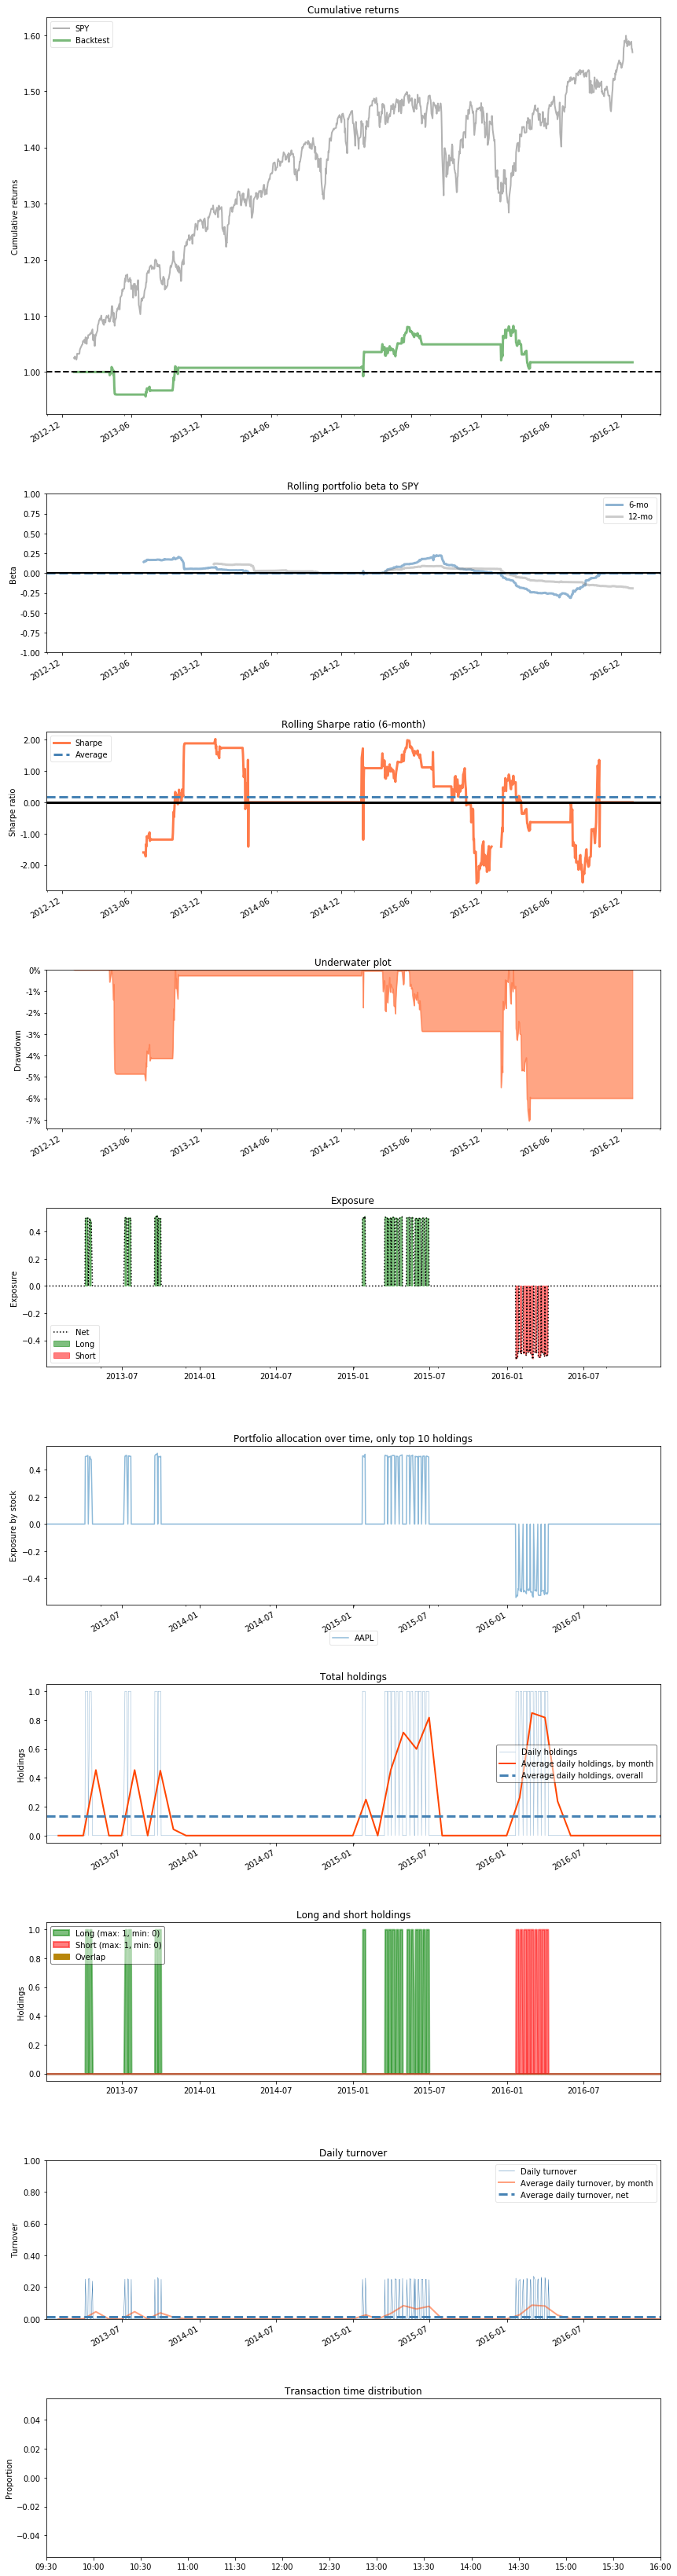

In [62]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)